# EFAS - puntos de cálculo
***

***Autor:** Jesús Casado*<br>
***Fecha:** 23-09-2023*<br>

**Introducción:**<br>
En este _notebook_ se comparan las estaciones del *Anuario de Aforos* seleccionadas para formar parte de CAMELS-ES con los puntos de cálculo de EFAS5. 

Lo ideal sería que los puntos de cálculo de EFAS coincidieran con las estaciones de CAMELS-ES. En ese caso, se podrían escoger los puntos calibrados en EFAS como puntos de entrenamiento para el modelo LSTM de CAMELS-ES, con lo que los resultados de ambos modelos calibrados sean comparables.

Sin embargo, como se muestra en este _notebook_, los puntos escogidos del *Anuario de Aforos* apenas coinciden con los puntos de cálculo de EFAS.

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import yaml
import geopandas as gpd
from shapely.geometry import Point
from tqdm.notebook import tqdm
import cartopy.crs as ccrs
import cartopy.feature as cf
from pathlib import Path

from metricas_rendimiento import KGE, KGEmod, ECDF
from anuario_aforos import extraer_caudal_estaciones, extraer_caudal_embalses, plot_caudal

## Configuración

In [2]:
with open("config.yml", "r", encoding='utf8') as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)

# ruta donde se ubican los datos del Anurio de Aforos
path_anuario = Path(cfg['rutas']['anuario_aforos']['repo'])
path_efas_in = Path(cfg['rutas']['EFAS']['orig'])
path_efas_out = Path(cfg['rutas']['EFAS']['repo'])

# inicio y fin del periodo de estudio
cfg_camels = cfg['CAMELS-ES']
start = cfg_camels['periodo'].get('inicio', None)
end = cfg_camels['periodo'].get('final', None)
start, end = [pd.to_datetime(i) for i in [start, end]]

# sistema de referencia de coordenadas de todos los datos
crs = cfg.get('crs', 4326)

## Capas
### Cuencas

In [3]:
# cargar polígono de las demarcaciones hidrográficas
cuencas_pol = gpd.read_file('../../data/cartografia/hidrografia/demarcaciones.shp')
cuencas_pol[['CUENCA_ID', 'COD_DEMAR']] = cuencas_pol[['CUENCA_ID', 'COD_DEMAR']].astype(int)
cuencas_pol.set_index('CUENCA_ID', drop=True, inplace=True)
cuencas_pol = cuencas_pol[~cuencas_pol.COD_DEMAR.isin([101, 61, 111, 121, 122, 123, 124, 125, 126, 127, 150, 63, 64, 160])]
cuencas_pol['pais'] = 'ES'

# disolver el polígono
area = cuencas_pol.dissolve(by='pais')

### Puntos
#### EFASv5

In [4]:
# cargar datos
efas = pd.read_csv(path_efas_in / '../points/indexes_ltr_efasnext.csv', index_col='ObsID')

# filtrar y renombrar columnas
efas_cols = {'National_Station_Identifier': 'origID',
             'StationName': 'name',
             'Provider ID': 'provider',
             'Country code': 'country',
             'StationLon': 'lon',
             'StationLat': 'lat',
             'LisfloodX': 'LisfloodX',
             'LisfloodY': 'LisfloodY',
             'Height': 'Z',
             'River': 'river',
             'EC_Catchments': 'catchment',
             'DrainingArea.km2.Provider': 'area_provi',
             'DrainingArea.km2.LDD': 'area_ldd',
             'FixedRepPoint': 'RepPoint',
             'Notes': 'Notes',
             'EC_calib': 'EC_calib',
             'KGE': 'KGE',
             'KGE_r': 'KGE_r',
             'KGE_B': 'KGE_B',
             'KGE_y': 'KGE_y',}
efas = efas[efas_cols.keys()].rename(columns=efas_cols)

# estaciones en España
efas['country'] = efas['country'].str.upper()
efas = efas[efas['country'] == 'ES']

# # mantener sólo puntos calibrados
# efas = efas[efas.EC_calib >= 1]

# convertir en GeoPandas
efas = gpd.GeoDataFrame(efas, geometry=[Point(xy) for xy in zip(efas['lon'], efas['lat'])])
efas.crs = f'EPSG:{crs}'

# recortar a las cuencas de estudio
efas = gpd.clip(efas, area.geometry)

EFAS tiene 613 puntos de cálculo (226 fueron calibrados).


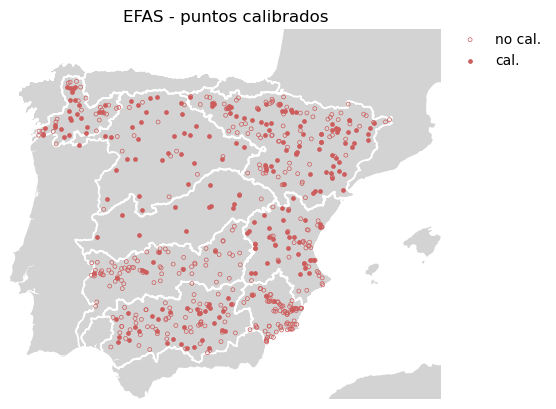

In [5]:
s = 8

# plot
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(subplot_kw={'projection': proj})
ax.add_feature(cf.NaturalEarthFeature('physical', 'land', '10m', edgecolor=None, facecolor='lightgray'), zorder=0)
ax.set_extent([-9.5, 3.5, 36, 44.5], crs=proj)
cuencas_pol.plot(ax=ax, facecolor='none', edgecolor='w', linewidth=1.2);
# puntos no calibrados
mask = efas.EC_calib == 0
ax.scatter(efas.loc[mask].geometry.x, efas.loc[mask].geometry.y,
           marker='o', facecolors='none', edgecolors='indianred', lw=.5, s=s, label='no cal.')
# puntos calibrados
mask = efas.EC_calib == 1
ax.scatter(efas.loc[mask].geometry.x, efas.loc[mask].geometry.y,
           marker='o', facecolors='indianred', edgecolors='indianred', lw=.5, s=s, label='cal.')
ax.set_title('EFAS - puntos calibrados')
ax.axis('off');
fig.legend(frameon=False, bbox_to_anchor=[.8, .6, .225, .3]);

# guardar mapa
path_plots = path_efas_out / 'plots'
if path_plots.exists() is False:
    path_plots.mkdir()
plt.savefig(path_plots / 'puntos_EFAS.jpg', dpi=300, bbox_inches='tight');

print('EFAS tiene {0} puntos de cálculo ({1} fueron calibrados).'.format(efas.shape[0],
                                                                         (efas.EC_calib == 1).sum()))

* No hay puntos en el Cantábrico ni en Galicia Costa.
* Hay muy pocos puntos en el Tajo, pero casi todos fueron calibrados.
* Hay un número considerable de puntos en el Guadiana y el Guadalquivir, mientras que en la selección de estaciones del Anuario de Aforos se seleccionaron muy pocas estaciones de estas cuencas puesto que las series eran malas.
* Algunos puntos de cálculo corresponden a embalses, no a estaciones de aforo.

#### Anuario de aforos

In [6]:
# cargar estaciones del anuario de aforos
estaciones = gpd.read_file(path_anuario / 'GIS/estaciones.shp')
estaciones.set_index('indroea', drop=True, inplace=True)

# cargar embalses del Anuario de Aforos
embalses = gpd.read_file(path_anuario / 'GIS/embalses.shp')
embalses.set_index('ref_ceh', drop=True, inplace=True)
embalses = embalses.rename(index={cod: f'{cod}_E' for cod in embalses.index[~embalses.index.str.contains('_E')]})

El Anuario de Aforos tiene 1074 estaciones (269 seleccionadas para CAMELS-ESP) y 394 embalses.


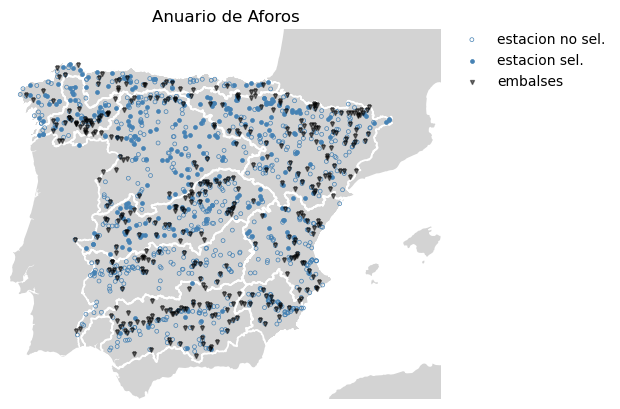

In [7]:
# plot
fig, ax = plt.subplots(subplot_kw={'projection': proj})
ax.add_feature(cf.NaturalEarthFeature('physical', 'land', '10m', edgecolor=None, facecolor='lightgray'), zorder=0)
ax.set_extent([-9.5, 3.5, 36, 44.5], crs=proj)
cuencas_pol.plot(ax=ax, facecolor='none', edgecolor='w', linewidth=1.2);
# estaciones no seleccionadas
mask = estaciones.sel == 0
ax.scatter(estaciones.loc[mask].geometry.x, estaciones.loc[mask].geometry.y,
           marker='o', facecolors='none', edgecolors='steelblue', lw=.5, s=s, label='estacion no sel.')
# estaciones seleccionadas
mask = estaciones.sel == 1
ax.scatter(estaciones.loc[mask].geometry.x, estaciones.loc[mask].geometry.y,
           marker='o', facecolors='steelblue', edgecolors='steelblue', lw=.5, s=s, label='estacion sel.')
# embalses
ax.scatter(embalses.geometry.x, embalses.geometry.y, c='k', marker='v', s=s, alpha=.5, label='embalses')
ax.axis('off')
ax.set_title('Anuario de Aforos')
fig.legend(frameon=False, bbox_to_anchor=[.9, .6, .225, .3]);

print('El Anuario de Aforos tiene {0} estaciones ({1} seleccionadas para CAMELS-ESP) y {2} embalses.'.format(estaciones.shape[0],
                                                                                                            (estaciones.sel == 1).sum(),
                                                                                                            embalses.shape[0]))

#### ID ROEA de los puntos EFAS

In [8]:
file_out = path_efas_out / 'GIS/reporting_points.shp'

if ('indroea' not in efas.columns) & (efas.index.name != 'indroea'):

    # convertir en coordenadas projectadas para poder calcular distancias
    efas = efas.to_crs(25830)
    estaciones = estaciones.to_crs(25830)
    embalses = embalses.to_crs(25830)
    
    # se toma el ID del punto más cercano (mínimo 10000 m)
    dist_max = 1e4
    efas['indroea'] = np.nan
    for id in tqdm(efas.index):
        x, y = efas.loc[[id]].geometry.x, efas.loc[[id]].geometry.y
        # estación del Anuario más cercana al punto EFAS
        dist = estaciones.distance(Point(x, y))
        dist = dist[dist < dist_max]
        if dist.shape[0] > 0:
            efas.loc[id, 'indroea'] = dist.idxmin()
        # embalse del Anuario más cercano al punto EFAS
        else:
            dist = embalses.distance(Point(x, y))
            dist = dist[dist < dist_max]
            if dist.shape[0] > 0:
                efas.loc[id, 'indroea'] = dist.idxmin()
    
    # definir sistema de coordenadas
    efas = efas.to_crs(4326)
    estaciones = estaciones.to_crs(4326)
    embalses = embalses.to_crs(4326)
    
    # ubicar los puntos en sus coordenadas en LISFLOOD
    geometry = [Point(lon, lat) for lon, lat in zip(efas.LisfloodX, efas.LisfloodY)]
    efas = gpd.GeoDataFrame(efas, geometry=geometry)

    # exportar
    efas.to_file(file_out, index=True)
else:

    # importar capa corregida
    efas = gpd.read_file(file_out)
    if ('ObsID' not in efas.columns) & (efas.index.name == 'ObsID'):
        efas['ObsID'] = efas.index
    efas.set_index('indroea', drop=True, inplace=True)

  0%|          | 0/613 [00:00<?, ?it/s]

C:\Users\jcr693\AppData\Local\Temp\ipykernel_15200\3158886491.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '5076' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  efas.loc[id, 'indroea'] = dist.idxmin()


Se seleccionaron 269 estaciones del Anuario de Aforos. 68 de ellas fueron calibradas en EFAS.


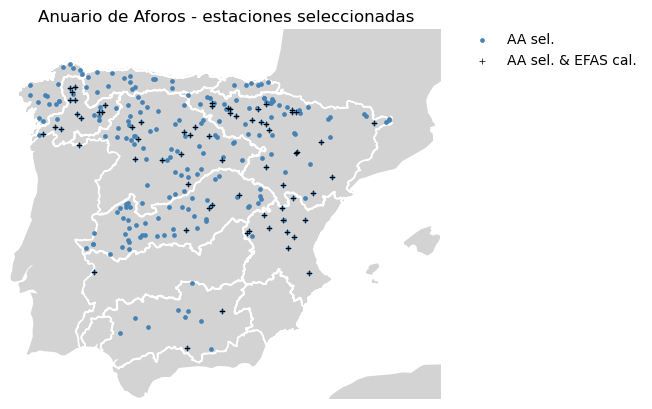

In [9]:
# plot
fig, ax = plt.subplots(subplot_kw={'projection': proj})
ax.add_feature(cf.NaturalEarthFeature('physical', 'land', '50m', edgecolor=None, facecolor='lightgray'), zorder=0)
ax.set_extent([-9.5, 3.5, 36, 44.5], crs=proj)
cuencas_pol.plot(ax=ax, facecolor='none', edgecolor='w', linewidth=1.2)
# estaciones seleccionadas
mask = estaciones.sel == 1
ax.scatter(estaciones.loc[mask].geometry.x, estaciones.loc[mask].geometry.y,
           marker='o', facecolors='steelblue', edgecolors='steelblue', lw=.5, s=s, label='AA sel.')
# estación seleccionada y calibrada en EFAS
mask_efas = estaciones.loc[mask].index.intersection(efas[efas.EC_calib == 1].indroea)
ax.scatter(estaciones.loc[mask_efas].geometry.x, estaciones.loc[mask_efas].geometry.y,
           c='k', marker='+', lw=.5, s=15, alpha=1, label='AA sel. & EFAS cal.');
ax.set_title('Anuario de Aforos - estaciones seleccionadas')
ax.axis('off');
fig.legend(frameon=False, bbox_to_anchor=[.95, .6, .225, .3]);

# guardar mapa
plt.savefig(path_plots / 'estaciones_ROEA_vs_EFAScal.jpg', dpi=300, bbox_inches='tight');

print('Se seleccionaron {0} estaciones del Anuario de Aforos. {1} de ellas fueron calibradas en EFAS.'.format(mask.sum(),
                                                                                                                len(mask_efas)))

Se calibraron 226 puntos en EFAS. De ellos, 68 han sido seleccionados del Anuario de Aforos


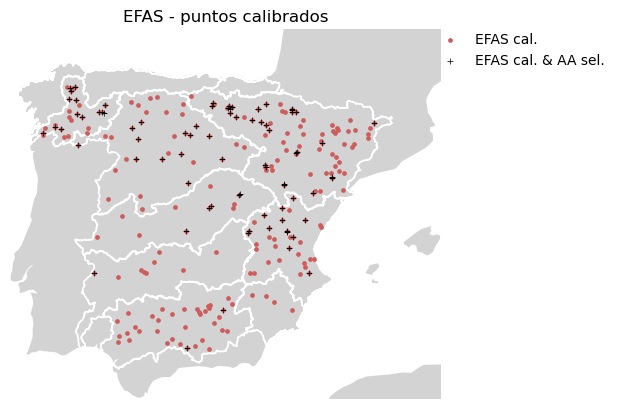

In [10]:
# plot
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(subplot_kw={'projection': proj})
ax.add_feature(cf.NaturalEarthFeature('physical', 'land', '50m', edgecolor=None, facecolor='lightgray'), zorder=0)
ax.set_extent([-9.5, 3.5, 36, 44.5], crs=proj)
cuencas_pol.plot(ax=ax, facecolor='none', edgecolor='w', linewidth=1.2);
# puntos calibrados
mask = efas.EC_calib == 1
ax.scatter(efas.loc[mask].geometry.x, efas.loc[mask].geometry.y,
           marker='o', facecolors='indianred', edgecolors='indianred', lw=.5, s=s, label='EFAS cal.')
# puntos calibrados y seleccionados del Anuario de Aforos
mask_AA = estaciones.loc[estaciones.sel == 1].index.intersection(efas.loc[mask, 'indroea'])
ax.scatter(efas.loc[efas.indroea.isin(mask_AA)].geometry.x, efas.loc[efas.indroea.isin(mask_AA)].geometry.y,
           c='k', marker='+', lw=.5, s=15, alpha=1, label='EFAS cal. & AA sel.');
ax.set_title('EFAS - puntos calibrados')
ax.axis('off');
fig.legend(frameon=False, bbox_to_anchor=[.9, .6, .225, .3]);

# guardar mapa
plt.savefig(path_plots / 'puntos_EFAS_vs_ROEAsel.jpg', dpi=300, bbox_inches='tight');

print('Se calibraron {0} puntos en EFAS. De ellos, {1} han sido seleccionados del Anuario de Aforos'.format(mask.sum(),
                                                                                                            len(mask_AA)))

De las 269 estaciones que se seleccionaron del Anuario de Aforos y las 226 que se calibraron en EFAS, sólo 68 coinciden entre estos dos conjuntos. 
* Buena parte de esas estaciones del Anuario que no se calibraron en EFAS corresponden al Cantábrico y Galicia Costa, cuyos estaciones no se incluían en la base de datos de EFAS.
* Los 3 puntos seleccionados del Segura no coinciden con los 4 que se calibraron.
* En la calibración se incluyeron muy pocos puntos del Tajo.
* Se calibraron un buen número de puntos del Guadalquivir, mientras que en la selección de estaciones del Anuario se encontraron muy pocos con series buenas.